<a href="https://colab.research.google.com/github/kingloogie/QTM-347-Machine-Learning-Final-Project/blob/main/ViT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive
from transformers import ViTFeatureExtractor, TFViTForImageClassification, create_optimizer, ViTImageProcessor
import tensorflow as tf
from pathlib import Path




In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === STEP 0: Mount Google Drive ===

clean_real = '/content/drive/MyDrive/QTM 347 Final Project/Cleaned_Image_Data_Folder/Extra Test/Extra Test Real'
clean_fake = '/content/drive/MyDrive/QTM 347 Final Project/Cleaned_Image_Data_Folder/Extra Test/Extra Test Fake'
base_train = '/content/dataset/train'
split_dataset = '/content/split_dataset'


In [ ]:

# === STEP 1: Copy cleaned data into Colab ===
# Mirror original data setup for Keras pipelines
# Define source and destination
real_src = clean_real
fake_src = clean_fake
real_dst = os.path.join(base_train, 'real')
fake_dst = os.path.join(base_train, 'fake')
os.makedirs(real_dst, exist_ok=True)
os.makedirs(fake_dst, exist_ok=True)
# Copy images
for src_path, dst_path in [(real_src, real_dst), (fake_src, fake_dst)]:
    for fname in os.listdir(src_path):
        src_file = os.path.join(src_path, fname)
        dst_file = os.path.join(dst_path, fname)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

Validating dataset structure...

✅ 961 images in 'Real'


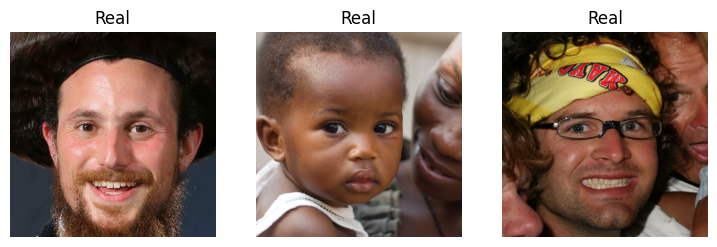

✅ 1000 images in 'Fake'


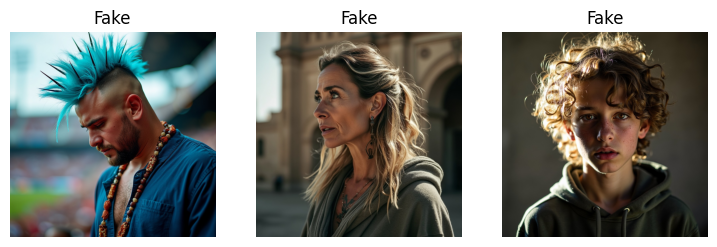

In [ ]:

# === STEP 2: Validate folder structure & show samples ===
def validate_dataset_structure(real_path, fake_path):
    print("Validating dataset structure...\n")
    for label, path in zip(['Real','Fake'], [real_path, fake_path]):
        files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        print(f"✅ {len(files)} images in '{label}'")
        sample = files[:3]
        plt.figure(figsize=(9,3))
        for i,fname in enumerate(sample):
            img = Image.open(os.path.join(path,fname))
            plt.subplot(1,3,i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label}")
        plt.show()
validate_dataset_structure(real_dst, fake_dst)


In [ ]:
# === STEP 3: Split into train/validation ===
# Use sklearn train_test_split to mirror original behavior
for label in ['real','fake']:
    src = os.path.join(base_train, label)
    imgs = [f for f in os.listdir(src) if f.lower().endswith(('jpg','jpeg','png'))]
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)
    for split_name, subset in zip(['train','validation'], [train_imgs, val_imgs]):
        dst = os.path.join(split_dataset, split_name, label)
        os.makedirs(dst, exist_ok=True)
        for img in subset:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))


In [ ]:

# === STEP 4: Set up ImageDataGenerators with Strong Augmentations ===
# Mirror original ImageDataGenerator usage but plug in stronger, more diverse augmentations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Use the enhanced augmentations
train_datagen = ImageDataGenerator(
    rescale=None, # CHANGED FROM 1./255
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7,1.3],
    shear_range=0.1,
    zoom_range=0.2,
    channel_shift_range=20
)

val_datagen = ImageDataGenerator(
    rescale=None # CHANGED FROM 1./255
)
# train_gen and val_gen will now yield uint8 images [0-255]
val_datagen = ImageDataGenerator(
    rescale=None  # only rescale for validation
)

# Create Keras generators from the enhanced augmentors
train_gen = train_datagen.flow_from_directory(
    os.path.join(split_dataset,'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(split_dataset,'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)


Found 1568 images belonging to 2 classes.
Found 393 images belonging to 2 classes.



--- Setting up Random Forest Test ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Setting up data generators for feature extraction (0-255 range, BHWC)...
Found 1568 images belonging to 2 classes.
Found 393 images belonging to 2 classes.
Extracting features for max 5000 samples (49 batches)...
  Processed batch 10/49, Samples: 320, Time: 14.85s
  Processed batch 20/49, Samples: 640, Time: 24.17s
  Processed batch 30/49, Samples: 960, Time: 33.19s
  Processed batch 40/49, Samples: 1280, Time: 41.65s
  Processed batch 49/49, Samples: 1568, Time: 48.92s
Extraction complete. Feature shape: (1568, 1280), Label shape: (1568,)
Extracting features for all 393 samples (13 batches)...
  Processed batch 10/13, Samples: 320, Time: 7.30s
  Processed batch 13/13, Samples: 393, Time: 14.52s
Extraction complete. Feature shape: (393, 1280), Label shape: (393,)

--- Training Random Forest Classifier ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


Random Forest training finished in 0.84 seconds.

--- Evaluating Random Forest ---
Random Forest Validation Accuracy: 0.9796

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.97      0.98       200
        real       0.97      0.98      0.98       193

    accuracy                           0.98       393
   macro avg       0.98      0.98      0.98       393
weighted avg       0.98      0.98      0.98       393


Confusion Matrix:
[[195   5]
 [  3 190]]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


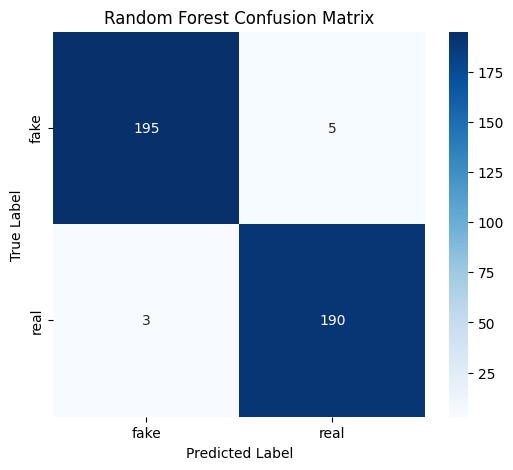

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix plotting
import time # To time feature extraction and training

# === STEP 9: Train a Random Forest Model using Extracted Features ===

print("\n--- Setting up Random Forest Test ---")

# --- Configuration ---
# Set this higher if you have enough RAM and want more robust RF training
MAX_SAMPLES_RF = 5000 # Limit samples to avoid excessive RAM usage/time. Adjust as needed.
N_ESTIMATORS_RF = 100 # Number of trees in the forest

# --- 1. Feature Extractor Setup ---
# Load MobileNetV2 pre-trained on ImageNet, without the top classification layer
base_model_rf = MobileNetV2(weights='imagenet', include_top=False,
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # Standard BHWC shape
                            pooling='avg') # Add global average pooling directly

# Make the base model non-trainable (we're just using it for feature extraction)
base_model_rf.trainable = False

# (Optional) You could create a tf.keras.Model if needed, but predict directly works
# feature_extractor_model = Model(inputs=base_model_rf.input, outputs=base_model_rf.output)
# print("Feature extractor model summary:")
# feature_extractor_model.summary() # Note: Input here might show None for batch size

# --- 2. Data Generators for Feature Extraction ---
# We need generators yielding images in the right format (0-255, BHWC) for MobileNetV2 preprocessing
print("Setting up data generators for feature extraction (0-255 range, BHWC)...")
rf_datagen = ImageDataGenerator(
    # IMPORTANT: Use the specific preprocessing function for MobileNetV2
    preprocessing_function=mobilenet_preprocess,
    rescale=None # Preprocessing function handles scaling/normalization
)

# Training generator - Shuffle ON (default)
train_gen_rf = rf_datagen.flow_from_directory(
    os.path.join(split_dataset,'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse', # Get integer labels
    shuffle=True
)

# Validation generator - Shuffle OFF is crucial to match labels correctly
val_gen_rf = rf_datagen.flow_from_directory(
    os.path.join(split_dataset,'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, # Can use larger batch for prediction
    class_mode='sparse',
    shuffle=False # DO NOT SHUFFLE validation data for extraction
)

# --- 3. Feature Extraction Function ---
def extract_features(generator, model, num_samples, max_samples=None):
    """Extracts features and labels from a generator."""
    features = []
    labels = []
    sample_count = 0
    start_time = time.time()

    num_batches = int(np.ceil(num_samples / generator.batch_size))
    if max_samples:
        num_batches = int(np.ceil(min(num_samples, max_samples) / generator.batch_size))
        print(f"Extracting features for max {max_samples} samples ({num_batches} batches)...")
    else:
        print(f"Extracting features for all {num_samples} samples ({num_batches} batches)...")


    for i, (x_batch, y_batch) in enumerate(generator):
        if max_samples and sample_count >= max_samples:
            break
        if i >= num_batches: # Safety break based on calculated batches
             break

        # Predict features using the base model
        batch_features = model.predict(x_batch, verbose=0)
        features.append(batch_features)
        labels.append(y_batch)
        sample_count += len(y_batch)

        if (i + 1) % 10 == 0 or (i + 1) == num_batches:
             elapsed = time.time() - start_time
             print(f"  Processed batch {i+1}/{num_batches}, Samples: {sample_count}, Time: {elapsed:.2f}s")

    # Concatenate all batches
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Ensure we didn't exceed max_samples if specified
    if max_samples:
        features = features[:max_samples]
        labels = labels[:max_samples]

    print(f"Extraction complete. Feature shape: {features.shape}, Label shape: {labels.shape}")
    return features, labels

# --- 4. Extract Features for Training and Validation Sets ---
# WARNING: This can take time and memory!
try:
    X_train_features, y_train_rf = extract_features(train_gen_rf, base_model_rf,
                                                 train_gen_rf.samples, MAX_SAMPLES_RF)
    X_val_features, y_val_rf = extract_features(val_gen_rf, base_model_rf,
                                             val_gen_rf.samples) # Extract all validation features

    # --- 5. Train Random Forest Classifier ---
    print("\n--- Training Random Forest Classifier ---")
    rf_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS_RF,
                                         random_state=42,
                                         n_jobs=-1, # Use all available CPU cores
                                         verbose=1) # Show some progress

    start_time = time.time()
    rf_classifier.fit(X_train_features, y_train_rf)
    end_time = time.time()
    print(f"Random Forest training finished in {end_time - start_time:.2f} seconds.")

    # --- 6. Evaluate Random Forest ---
    print("\n--- Evaluating Random Forest ---")
    y_pred_rf = rf_classifier.predict(X_val_features)

    accuracy_rf = accuracy_score(y_val_rf, y_pred_rf)
    print(f"Random Forest Validation Accuracy: {accuracy_rf:.4f}")
    print("\nClassification Report:")
    # Use target_names from one of the generators
    class_names = list(val_gen_rf.class_indices.keys())
    print(classification_report(y_val_rf, y_pred_rf, target_names=class_names))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val_rf, y_pred_rf)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Random Forest Confusion Matrix')
    plt.show()

except MemoryError:
    print("\n--- MEMORY ERROR ---")
    print("Failed to extract features due to insufficient RAM.")
    print(f"Consider reducing MAX_SAMPLES_RF (currently {MAX_SAMPLES_RF}) or using")
    print("dimensionality reduction (PCA) on features, or batch training methods.")
except Exception as e:
    print(f"\n--- An Error Occurred ---")
    print(f"Error during Random Forest pipeline: {e}")

In [ ]:
# In Step 5 - MODIFY the wrap_generator_corrected function AGAIN

vit_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(vit_name)

def wrap_generator_corrected(keras_gen):
    while True:
        # 1. Get raw batch (BHWC, uint8 or float32, 0-255 - ASSUMING rescale=None in datagen)
        x_batch_raw, y_batch = next(keras_gen)

        # 2. Process using ViTImageProcessor
        # Processor outputs BCHW format based on our previous check
        inputs = processor(
            images=x_batch_raw, # Pass numpy array directly
            return_tensors="tf",
            do_rescale=True,    # Let processor handle rescaling from [0-255]
            do_normalize=True   # Let processor handle normalization
        )
        pixel_values_bchw = inputs['pixel_values'] # This is likely (Batch, 3, 224, 224)

        # 3. --- REMOVED THE TRANSPOSE ---
        # pixel_values_bhwc = tf.transpose(pixel_values_bchw, (0, 2, 3, 1)) # DELETE OR COMMENT OUT THIS LINE

        # 4. Yield the direct processor output (BCHW)
        # Feed the model the Channels-First tensor
        yield {'pixel_values': pixel_values_bchw}, y_batch # Yield BCHW

# --- Make sure to re-run the cell defining this function ---

# Re-wrap the generators with the newly modified function
train_wrapped = wrap_generator_corrected(train_gen)
val_wrapped = wrap_generator_corrected(val_gen)

In [ ]:

# === STEP 6: Build & Compile ViT Model ===
vit_name = "google/vit-base-patch16-224-in21k"

model = TFViTForImageClassification.from_pretrained(
    vit_name,
    num_labels=2,
    id2label={0: 'real', 1: 'fake'},
    label2id={'real': 0, 'fake': 1}
)
model.config.return_dict = True
# Optimizer
epochs = 3
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE
optimizer, _ = create_optimizer(
    init_lr=1e-4,
    num_train_steps=steps_per_epoch * epochs,
    num_warmup_steps=0
)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# === Baseline: Untuned ViT Evaluation (Multiple Runs) ===
# Run the pretrained model evaluation multiple times to gauge stability
def evaluate_untuned(runs=3):
    losses, accs = [], []
    for i in range(runs):
        print(f"Run {i+1}/{runs}")
        result = model.evaluate(
            val_wrapped,
            steps=validation_steps,
            verbose=1
        )
        losses.append(result[0])
        accs.append(result[1])
    print(f"Untuned ViT over {runs} runs:")
    print(f"  Avg loss = {np.mean(losses):.4f} ± {np.std(losses):.4f}")
    print(f"  Avg acc  = {np.mean(accs):.4f} ± {np.std(accs):.4f}")
evaluate_untuned(runs=3)


Run 1/3
12/12 [==============================] - 19s 1s/step - loss: 0.7149 - accuracy: 0.3516
Run 2/3
12/12 [==============================] - 14s 1s/step - loss: 0.7154 - accuracy: 0.3490
Run 3/3
12/12 [==============================] - 14s 1s/step - loss: 0.7150 - accuracy: 0.3516
Untuned ViT over 3 runs:
  Avg loss = 0.7151 ± 0.0002
  Avg acc  = 0.3507 ± 0.0012


Epoch 1/3
49/49 [==============================] - 132s 2s/step - loss: 0.1544 - accuracy: 0.9668 - val_loss: 0.0274 - val_accuracy: 0.9974
Epoch 2/3
49/49 [==============================] - 93s 2s/step - loss: 0.0209 - accuracy: 0.9974 - val_loss: 0.0190 - val_accuracy: 0.9974
Epoch 3/3
49/49 [==============================] - 91s 2s/step - loss: 0.0152 - accuracy: 0.9994 - val_loss: 0.0147 - val_accuracy: 0.9974


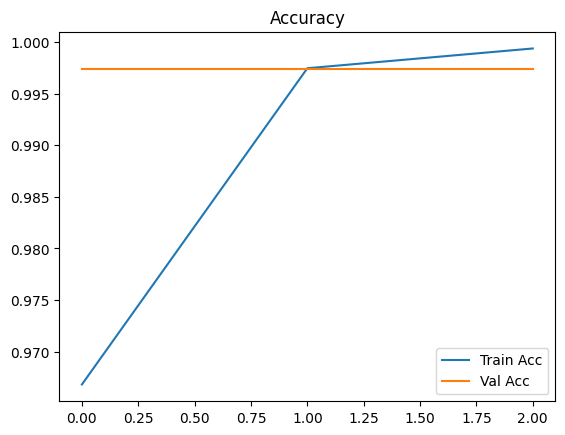

In [ ]:

# === STEP 7: Initial Training ===
hist = model.fit(
    train_wrapped,
    validation_data=val_wrapped,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs
)
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.show()


In [ ]:

# 1. Gather all true labels and model predictions on the validation set
y_true, y_pred = [], []
for X_batch, y_batch in val_wrapped:
    y_true.extend(y_batch.tolist())
    logits = model.predict(X_batch, verbose=0).logits
    y_pred.extend(np.argmax(logits, axis=-1).tolist())
    if len(y_true) >= val_gen.samples:
        break  # only one pass

y_true = np.array(y_true)[:val_gen.samples]
y_pred = np.array(y_pred)[:val_gen.samples]

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["real","fake"], yticklabels=["real","fake"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report
print(classification_report(y_true, y_pred, target_names=["real","fake"]))



--- Setting up Simple CNN Test ---
Created unpacking generators for simple CNN.


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 222, 222)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 111, 111)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 109, 109)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 54, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 52, 52)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 26, 26)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Simple CNN ---
Epoch 1/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7281 - loss: 0.5127 - val_accuracy: 0.9557 - val_loss: 0.1428
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8745 - loss: 0.2919 - val_accuracy: 0.9557 - val_loss: 0.1330
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9304 - loss: 0.1891 - val_accuracy: 0.9583 - val_loss: 0.0964

--- Simple CNN Training Results ---


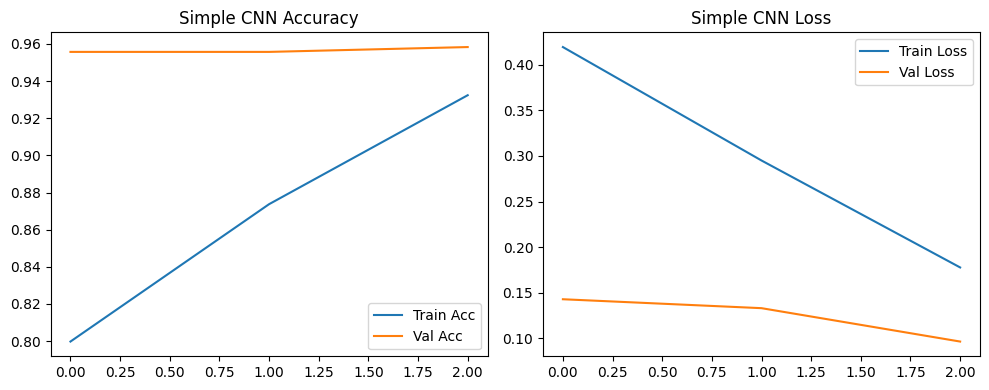


--- Evaluating Simple CNN on Validation Set ---
Simple CNN Final Validation Loss: 0.0792
Simple CNN Final Validation Accuracy: 0.9640


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported if not already

# === STEP 8: Train a Simple CNN for Comparison ===

print("\n--- Setting up Simple CNN Test ---")

# Define the simple CNN model
def create_simple_cnn(input_shape=(3, 224, 224), num_classes=2):
    """
    Creates a simple CNN model using Keras Sequential API.
    Expects Channels-First input format (channels, height, width).
    """
    model = Sequential([
        # Specify input shape and data format for the first layer
        Input(shape=input_shape, name="pixel_values"), # Use same input name as ViT wrapper yields
        Conv2D(32, kernel_size=(3, 3), activation='relu', data_format='channels_first'),
        MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', data_format='channels_first'),
        MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', data_format='channels_first'),
        MaxPooling2D(pool_size=(2, 2), data_format='channels_first'),
        Flatten(),
        Dropout(0.5), # Add dropout for regularization
        Dense(128, activation='relu'),
        Dense(num_classes) # No activation, using from_logits=True in loss
    ], name="simple_cnn")
    return model

# --- Data Generator Compatibility ---
# Keras model.fit expects the generator to yield (inputs, targets).
# Our current wrap_generator_corrected yields ({'pixel_values': inputs}, targets).
# We need a small wrapper to unpack this for the standard Keras model.

def unpack_dict_generator(wrapped_gen):
    """Takes the generator yielding {'pixel_values': x}, y and yields x, y"""
    for batch in wrapped_gen:
        # batch[0] is the dictionary {'pixel_values': x_tensor}
        # batch[1] is the label tensor y_tensor
        yield batch[0]['pixel_values'], batch[1]

# Use the same wrapped generators from the ViT setup
# IMPORTANT: Assumes train_wrapped and val_wrapped are still defined and working
# from the previous ViT setup using wrap_generator_corrected
if 'train_wrapped' not in locals() or 'val_wrapped' not in locals():
    print("ERROR: 'train_wrapped' or 'val_wrapped' not defined. Rerun previous cells.")
    # Or redefine them here if necessary, ensuring wrap_generator_corrected is correct
else:
    simple_cnn_train_gen = unpack_dict_generator(train_wrapped)
    simple_cnn_val_gen = unpack_dict_generator(val_wrapped)
    print("Created unpacking generators for simple CNN.")

    # Create and compile the simple CNN
    # Use the input shape yielded by wrap_generator_corrected (BCHW) -> (3, 224, 224)
    input_channels = 3 # Defined by the processor/input images
    simple_cnn_model = create_simple_cnn(input_shape=(input_channels, IMG_HEIGHT, IMG_WIDTH), num_classes=2)

    simple_cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Standard Adam optimizer
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Same loss as ViT
        metrics=['accuracy']
    )

    simple_cnn_model.summary()

    # Train the simple CNN
    print("\n--- Training Simple CNN ---")
    # Use the same steps/epochs configuration as ViT for comparison
    # Make sure steps_per_epoch and validation_steps are calculated correctly based on your dataset size
    if 'steps_per_epoch' not in locals() or 'validation_steps' not in locals():
         print("Calculating steps per epoch again...")
         # Need access to the original generators to get sample counts
         if 'train_gen' in locals() and 'val_gen' in locals():
              steps_per_epoch = train_gen.samples // BATCH_SIZE
              validation_steps = val_gen.samples // BATCH_SIZE
              print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")
         else:
              print("ERROR: Cannot calculate steps. train_gen/val_gen not found.")
              # Set some default or stop if you can't recalculate
              steps_per_epoch = 50 # Example fallback
              validation_steps = 10 # Example fallback


    simple_cnn_hist = simple_cnn_model.fit(
        simple_cnn_train_gen,
        validation_data=simple_cnn_val_gen,
        epochs=epochs, # Use same number of epochs as ViT
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1 # Show progress
    )

    # Plot the results
    print("\n--- Simple CNN Training Results ---")
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(simple_cnn_hist.history['accuracy'], label='Train Acc')
    plt.plot(simple_cnn_hist.history['val_accuracy'], label='Val Acc')
    plt.title('Simple CNN Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(simple_cnn_hist.history['loss'], label='Train Loss')
    plt.plot(simple_cnn_hist.history['val_loss'], label='Val Loss')
    plt.title('Simple CNN Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate final performance
    print("\n--- Evaluating Simple CNN on Validation Set ---")
    loss, accuracy = simple_cnn_model.evaluate(simple_cnn_val_gen, steps=validation_steps, verbose=0)
    print(f"Simple CNN Final Validation Loss: {loss:.4f}")
    print(f"Simple CNN Final Validation Accuracy: {accuracy:.4f}")